## Compare results for multiple results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import subprocess as sp
import os
import glob
import sys

import itertools
import time

from ipywidgets import *

In [2]:
%matplotlib notebook

In [3]:
# sys.path.append('/global/u1/v/vpa/project/jpt_notebooks/Cosmology/Cosmo_GAN/repositories/cosmogan_pytorch/code/modules_image_analysis/')
from modules_img_analysis import *

In [4]:
### Transformation functions for image pixel values
def f_transform(x,a):
    return 2.*x/(x + float(a)) - 1.

def f_invtransform(s,a):
    return float(a)*(1. + s)/(1. - s)


In [5]:
def f_compute_hist_spect(sample,bins):
    ''' Compute pixel intensity histograms and radial spectrum for 2D arrays
    Input : Image arrays and bins
    Output: dictionary with 5 arrays : Histogram values, errors and bin centers, Spectrum values and errors.
    '''
    ### Compute pixel histogram for row
    gen_hist,gen_err,hist_bins=f_batch_histogram(sample,bins=bins,norm=True,hist_range=None)
    ### Compute spectrum for row
    spec,spec_sdev=f_plot_spectrum_3d(sample,plot=False)

    dict1={'hist_val':gen_hist,'hist_err':gen_err,'hist_bin_centers':hist_bins,'spec_val':spec,'spec_sdev':spec_sdev }
    return dict1


def f_compute_chisqr(dict_val,dict_sample,img_size):
    '''
    Compute chi-square values for sample w.r.t input images
    Input: 2 dictionaries with 4 keys for histogram and spectrum values and errors
    '''
    ### !!Both pixel histograms MUST have same bins and normalization!
    ### Compute chi-sqr
    ### Used in keras code : np.sum(np.divide(np.power(valhist - samphist, 2.0), valhist))
    ###  chi_sqr :: sum((Obs-Val)^2/(Val))
    
    chisqr_dict={}
    
    try: 
        val_dr=dict_val['hist_val'].copy()
        val_dr[val_dr<=0.]=1.0    ### Avoiding division by zero for zero bins

        sq_diff=(dict_val['hist_val']-dict_sample['hist_val'])**2

        size=len(dict_val['hist_val'])
        l1,l2=int(size*0.3),int(size*0.7)
        keys=['chi_1a','chi_1b','chi_1c','chi_1']
        
        for (key,start,end) in zip(keys,[0,l1,l2,0],[l1,l2,None,None]):  # 4 lists : small, medium, large pixel values and full 
            chisqr_dict.update({key:np.sum(np.divide(sq_diff[start:end],val_dr[start:end]))})

        idx=None  # Choosing the number of histograms to use. Eg : -5 to skip last 5 bins
    #     chisqr_dict.update({'chi_sqr1':})

        chisqr_dict.update({'chi_2':np.sum(np.divide(sq_diff[:idx],1.0))}) ## chi-sqr without denominator division
        chisqr_dict.update({'chi_imgvar':np.sum(dict_sample['hist_err'][:idx])/np.sum(dict_val['hist_err'][:idx])}) ## measures total spread in histograms wrt to input data

        idx=img_size
        spec_diff=(dict_val['spec_val']-dict_sample['spec_val'])**2
        ### computing the spectral loss chi-square
        chisqr_dict.update({'chi_spec1':np.sum(spec_diff[:idx]/dict_sample['spec_val'][:idx]**2)})

        ### computing the spectral loss chi-square
        chisqr_dict.update({'chi_spec2':np.sum(spec_diff[:idx]/dict_sample['spec_sdev'][:idx]**2)})
        
        spec_loss=1.0*np.log(np.mean((dict_val['spec_val'][:idx]-dict_sample['spec_val'][:idx])**2))+1.0*np.log(np.mean((dict_val['spec_sdev'][:idx]-dict_sample['spec_sdev'][:idx])**2))
        chisqr_dict.update({'chi_spec3':spec_loss})
    
    except Exception as e: 
        print(e)
        
        keys=['chi_1a','chi_1b','chi_1c','chi_1','chi_2','chi_imgvar','chi_spec1','chi_spec2']
        chisqr_dict=dict.fromkeys(keys,np.nan)
        pass
    
    return chisqr_dict
    

In [6]:
img_size=64
# img_size=128

kappa=4

In [7]:
val_data_dict={'64':'/p/vast1/lbann/datasets/exagan/portal.nersc.gov/project/m3363/transfer_data_livermore/64cube_dataset/norm_1_train_val.npy',
              '128':''}


In [8]:
### Read validation data
# bins=np.concatenate([np.array([-0.5]),np.arange(0.5,20.5,1),np.arange(20.5,100.5,5),np.arange(100.5,1000.5,50),np.array([2000])]) #bin edges to use
bins=np.concatenate([np.array([-0.5]),np.arange(0.5,100.5,5),np.arange(100.5,300.5,20),np.arange(300.5,1000.5,50),np.array([2000])]) #bin edges to use
bins=f_transform(bins,kappa)   ### scale to (-1,1)

bkgnd_dict={}
num_bkgnd=100

### Extract validation data   
samples=np.load(val_data_dict[str(img_size)],mmap_mode='r')[500:600].copy()[:,0,:,:,:]
dict_val=f_compute_hist_spect(samples,bins)
del samples


In [9]:
# a1=f_invtransform(samples[0],4.0)
# np.max(a1),np.min(a1)

### Add runs

In [11]:
df_runs=pd.DataFrame([])

In [12]:
# Run 1 : D = 1

fldr='20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv'
steps=[3450,3750,6000,6300]
prefix='D1'

parent_dir='/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/'
run_fldr=parent_dir+fldr

print(run_fldr)
output_fldr=run_fldr+'/outputs/trainer0/model0/'

file_lst=[]
for i in steps:
    j=glob.glob(output_fldr+'sgd.validation*.step.{0}_gen_img*.npy'.format(i))[0]
    file_lst.append(j)

print(file_lst)

for count,fname in enumerate(file_lst[:]):
    epoch=int(fname.split('/')[-1].split('.')[3])
    step=int(fname.split('/')[-1].split('.')[5].split('_')[0])
    
    key = prefix+'_%s_%s'%(epoch,step)

    print(key)

    dict1={'label':key,'fname':fname}
    images=np.load(dict1['fname'])     ### No transform needed here

    images=images[:,0,:,:,:]
    print(images.shape)
    print(np.max(images),np.min(images))

    dict1['num_imgs']=images.shape[0]
    print(dict1)
    ### Compute spectrum and histograms
    dict_sample=f_compute_hist_spect(images,bins)
    ### Compute chi squares
    dict_chisqrs=f_compute_chisqr(dict_val,dict_sample,img_size)

    dict1.update(dict_sample)
    dict1.update(dict_chisqrs)
    del(images)
    
#     df_runs=pd.concat([df_runs,pd.DataFrame(dict1,index=[df_runs.shape[0]+1])])
    df_runs=df_runs.append(dict1,ignore_index=True)

/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv
['/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv/outputs/trainer0/model0/sgd.validation.epoch.25.step.3450_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv/outputs/trainer0/model0/sgd.validation.epoch.27.step.3750_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv/outputs/trainer0/model0/sgd.validation.epoch.43.step.6000_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv/outputs/trainer0/model0/sgd.validation.epoch.45.step.6300_gen_img_instance1_activation_output0.npy']
D1_25_3450


/tmp/ipykernel_96966/3089452563.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D1_27_3750
(16, 64, 64, 64)
0.9984598 -0.9999968
{'label': 'D1_27_3750', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv/outputs/trainer0/model0/sgd.validation.epoch.27.step.3750_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/3089452563.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D1_43_6000
(16, 64, 64, 64)
0.99653494 -0.99997437
{'label': 'D1_43_6000', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv/outputs/trainer0/model0/sgd.validation.epoch.43.step.6000_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/3089452563.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D1_45_6300
(16, 64, 64, 64)
0.99733424 -0.99995065
{'label': 'D1_45_6300', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv/outputs/trainer0/model0/sgd.validation.epoch.45.step.6300_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/3089452563.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


In [13]:
# Run 2 : D = 2

fldr='20230530_142336_lbann_cosmo3DGAN_n8_ppn4_D2_distconv'
steps=[2500,2750,3250,10000]
prefix='D2'

parent_dir='/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/'
run_fldr=parent_dir+fldr

print(run_fldr)
output_fldr=run_fldr+'/outputs/trainer0/model0/'

file_lst=[]
for i in steps:
    j=glob.glob(output_fldr+'sgd.validation*.step.{0}_gen_img*.npy'.format(i))[0]
    file_lst.append(j)

print(file_lst)

for count,fname in enumerate(file_lst[:]):
    epoch=int(fname.split('/')[-1].split('.')[3])
    step=int(fname.split('/')[-1].split('.')[5].split('_')[0])
    
    key = prefix+'_%s_%s'%(epoch,step)

    print(key)

    dict1={'label':key,'fname':fname}
    images=np.load(dict1['fname'])     ### No transform needed here

    images=images[:,0,:,:,:]
    print(images.shape)
    print(np.max(images),np.min(images))

    dict1['num_imgs']=images.shape[0]
    print(dict1)
    ### Compute spectrum and histograms
    dict_sample=f_compute_hist_spect(images,bins)
    ### Compute chi squares
    dict_chisqrs=f_compute_chisqr(dict_val,dict_sample,img_size)

    dict1.update(dict_sample)
    dict1.update(dict_chisqrs)
    del(images)
    
#     df_runs=pd.concat([df_runs,pd.DataFrame(dict1,index=[df_runs.shape[0]+1])])
    df_runs=df_runs.append(dict1,ignore_index=True)

/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142336_lbann_cosmo3DGAN_n8_ppn4_D2_distconv
['/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142336_lbann_cosmo3DGAN_n8_ppn4_D2_distconv/outputs/trainer0/model0/sgd.validation.epoch.18.step.2500_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142336_lbann_cosmo3DGAN_n8_ppn4_D2_distconv/outputs/trainer0/model0/sgd.validation.epoch.19.step.2750_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142336_lbann_cosmo3DGAN_n8_ppn4_D2_distconv/outputs/trainer0/model0/sgd.validation.epoch.23.step.3250_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142336_lbann_cosmo3DGAN_n8_ppn4_D2_distconv/outputs/trainer0/model0/sgd.validation.epoch.72.step.10000_gen_img_instance1_activation_output0.npy']
D2_18_2500

/tmp/ipykernel_96966/635758512.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D2_19_2750
(16, 64, 64, 64)
0.9986276 -0.9998703
{'label': 'D2_19_2750', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142336_lbann_cosmo3DGAN_n8_ppn4_D2_distconv/outputs/trainer0/model0/sgd.validation.epoch.19.step.2750_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/635758512.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D2_23_3250
(16, 64, 64, 64)
0.99773896 -0.9997672
{'label': 'D2_23_3250', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142336_lbann_cosmo3DGAN_n8_ppn4_D2_distconv/outputs/trainer0/model0/sgd.validation.epoch.23.step.3250_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/635758512.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D2_72_10000
(16, 64, 64, 64)
0.9972108 -0.9995685
{'label': 'D2_72_10000', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142336_lbann_cosmo3DGAN_n8_ppn4_D2_distconv/outputs/trainer0/model0/sgd.validation.epoch.72.step.10000_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/635758512.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


In [14]:
# Run 3 : D = 4

fldr='20230530_142323_lbann_cosmo3DGAN_n8_ppn4_D4_distconv'
steps=[7300,8000,9750]
prefix='D4'

parent_dir='/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/'
run_fldr=parent_dir+fldr

print(run_fldr)
output_fldr=run_fldr+'/outputs/trainer0/model0/'

file_lst=[]
for i in steps:
    j=glob.glob(output_fldr+'sgd.validation*.step.{0}_gen_img*.npy'.format(i))[0]
    file_lst.append(j)

print(file_lst)

for count,fname in enumerate(file_lst[:]):
    epoch=int(fname.split('/')[-1].split('.')[3])
    step=int(fname.split('/')[-1].split('.')[5].split('_')[0])
    
    key = prefix+'_%s_%s'%(epoch,step)

    print(key)

    dict1={'label':key,'fname':fname}
    images=np.load(dict1['fname'])     ### No transform needed here

    images=images[:,0,:,:,:]
    print(images.shape)
    print(np.max(images),np.min(images))

    dict1['num_imgs']=images.shape[0]
    print(dict1)
    ### Compute spectrum and histograms
    dict_sample=f_compute_hist_spect(images,bins)
    ### Compute chi squares
    dict_chisqrs=f_compute_chisqr(dict_val,dict_sample,img_size)

    dict1.update(dict_sample)
    dict1.update(dict_chisqrs)
    del(images)
    
#     df_runs=pd.concat([df_runs,pd.DataFrame(dict1,index=[df_runs.shape[0]+1])])
    df_runs=df_runs.append(dict1,ignore_index=True)

/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142323_lbann_cosmo3DGAN_n8_ppn4_D4_distconv
['/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142323_lbann_cosmo3DGAN_n8_ppn4_D4_distconv/outputs/trainer0/model0/sgd.validation.epoch.52.step.7300_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142323_lbann_cosmo3DGAN_n8_ppn4_D4_distconv/outputs/trainer0/model0/sgd.validation.epoch.57.step.8000_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142323_lbann_cosmo3DGAN_n8_ppn4_D4_distconv/outputs/trainer0/model0/sgd.validation.epoch.70.step.9750_gen_img_instance1_activation_output0.npy']
D4_52_7300
(16, 64, 64, 64)
0.9977818 -0.999088
{'label': 'D4_52_7300', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142323_lbann_cosmo3DGAN_n8_ppn4_D4_distconv/outputs/trainer0/model0/sgd.val

/tmp/ipykernel_96966/2824807495.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D4_57_8000
(16, 64, 64, 64)
0.996949 -0.9991865
{'label': 'D4_57_8000', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142323_lbann_cosmo3DGAN_n8_ppn4_D4_distconv/outputs/trainer0/model0/sgd.validation.epoch.57.step.8000_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/2824807495.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D4_70_9750
(16, 64, 64, 64)
0.9979483 -0.99853057
{'label': 'D4_70_9750', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230530_142323_lbann_cosmo3DGAN_n8_ppn4_D4_distconv/outputs/trainer0/model0/sgd.validation.epoch.70.step.9750_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/2824807495.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


In [15]:
# Run 4 : D = 8

fldr='20230525_111759_lbann_cosmo3DGAN_n8_ppn4_D8'
steps=[10000,7500,8550,9750]
prefix='D8'

parent_dir='/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/'
run_fldr=parent_dir+fldr

print(run_fldr)
output_fldr=run_fldr+'/outputs/trainer0/model0/'

file_lst=[]
for i in steps:
    j=glob.glob(output_fldr+'sgd.validation*.step.{0}_gen_img*.npy'.format(i))[0]
    file_lst.append(j)

print(file_lst)

for count,fname in enumerate(file_lst[:]):
    epoch=int(fname.split('/')[-1].split('.')[3])
    step=int(fname.split('/')[-1].split('.')[5].split('_')[0])
    
    key = prefix+'_%s_%s'%(epoch,step)

    print(key)

    dict1={'label':key,'fname':fname}
    images=np.load(dict1['fname'])     ### No transform needed here

    images=images[:,0,:,:,:]
    print(images.shape)
    print(np.max(images),np.min(images))

    dict1['num_imgs']=images.shape[0]
    print(dict1)
    ### Compute spectrum and histograms
    dict_sample=f_compute_hist_spect(images,bins)
    ### Compute chi squares
    dict_chisqrs=f_compute_chisqr(dict_val,dict_sample,img_size)

    dict1.update(dict_sample)
    dict1.update(dict_chisqrs)
    del(images)
    
#     df_runs=pd.concat([df_runs,pd.DataFrame(dict1,index=[df_runs.shape[0]+1])])
    df_runs=df_runs.append(dict1,ignore_index=True)

/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_111759_lbann_cosmo3DGAN_n8_ppn4_D8
['/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_111759_lbann_cosmo3DGAN_n8_ppn4_D8/outputs/trainer0/model0/sgd.validation.epoch.72.step.10000_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_111759_lbann_cosmo3DGAN_n8_ppn4_D8/outputs/trainer0/model0/sgd.validation.epoch.54.step.7500_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_111759_lbann_cosmo3DGAN_n8_ppn4_D8/outputs/trainer0/model0/sgd.validation.epoch.61.step.8550_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_111759_lbann_cosmo3DGAN_n8_ppn4_D8/outputs/trainer0/model0/sgd.validation.epoch.70.step.9750_gen_img_instance1_activation_output0.npy']
D8_72_10000
(16, 64, 64, 64)
0.99551076 -0.9997434
{'la

/tmp/ipykernel_96966/2691725001.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D8_54_7500
(16, 64, 64, 64)
0.995912 -0.9997671
{'label': 'D8_54_7500', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_111759_lbann_cosmo3DGAN_n8_ppn4_D8/outputs/trainer0/model0/sgd.validation.epoch.54.step.7500_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/2691725001.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D8_61_8550
(16, 64, 64, 64)
0.9965889 -0.9994466
{'label': 'D8_61_8550', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_111759_lbann_cosmo3DGAN_n8_ppn4_D8/outputs/trainer0/model0/sgd.validation.epoch.61.step.8550_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/2691725001.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D8_70_9750
(16, 64, 64, 64)
0.99772364 -0.9997819
{'label': 'D8_70_9750', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_111759_lbann_cosmo3DGAN_n8_ppn4_D8/outputs/trainer0/model0/sgd.validation.epoch.70.step.9750_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/2691725001.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


In [16]:
# Run 5 : D = 16

fldr='20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16'
steps=[4500,9000,4700,9100]
prefix='D16'

parent_dir='/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/'
run_fldr=parent_dir+fldr

print(run_fldr)
output_fldr=run_fldr+'/outputs/trainer0/model0/'

file_lst=[]
for i in steps:
    j=glob.glob(output_fldr+'sgd.validation*.step.{0}_gen_img*.npy'.format(i))[0]
    file_lst.append(j)

print(file_lst)

for count,fname in enumerate(file_lst[:]):
    epoch=int(fname.split('/')[-1].split('.')[3])
    step=int(fname.split('/')[-1].split('.')[5].split('_')[0])
    
    key = prefix+'_%s_%s'%(epoch,step)

    print(key)

    dict1={'label':key,'fname':fname}
    images=np.load(dict1['fname'])     ### No transform needed here

    images=images[:,0,:,:,:]
    print(images.shape)
    print(np.max(images),np.min(images))

    dict1['num_imgs']=images.shape[0]
    print(dict1)
    ### Compute spectrum and histograms
    dict_sample=f_compute_hist_spect(images,bins)
    ### Compute chi squares
    dict_chisqrs=f_compute_chisqr(dict_val,dict_sample,img_size)

    dict1.update(dict_sample)
    dict1.update(dict_chisqrs)
    del(images)
    
#     df_runs=pd.concat([df_runs,pd.DataFrame(dict1,index=[df_runs.shape[0]+1])])
    df_runs=df_runs.append(dict1,ignore_index=True)

/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16
['/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16/outputs/trainer0/model0/sgd.validation.epoch.32.step.4500_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16/outputs/trainer0/model0/sgd.validation.epoch.65.step.9000_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16/outputs/trainer0/model0/sgd.validation.epoch.34.step.4700_gen_img_instance1_activation_output0.npy', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16/outputs/trainer0/model0/sgd.validation.epoch.65.step.9100_gen_img_instance1_activation_output0.npy']
D16_32_4500
(16, 64, 64, 64)
0.996491 -0.99820894
{

/tmp/ipykernel_96966/2409832532.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D16_65_9000
(16, 64, 64, 64)
0.9958929 -0.9974114
{'label': 'D16_65_9000', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16/outputs/trainer0/model0/sgd.validation.epoch.65.step.9000_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/2409832532.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D16_34_4700
(16, 64, 64, 64)
0.99773514 -0.9982946
{'label': 'D16_34_4700', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16/outputs/trainer0/model0/sgd.validation.epoch.34.step.4700_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/2409832532.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


D16_65_9100
(16, 64, 64, 64)
0.99826604 -0.99697757
{'label': 'D16_65_9100', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16/outputs/trainer0/model0/sgd.validation.epoch.65.step.9100_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/2409832532.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


In [17]:
## Add a reference set of images

prefix='run_ref'
key=prefix
print(key)

dict1={'label':key,'fname':fname}

images=np.load(val_data_dict[str(img_size)],mmap_mode='r')[16:32].copy()[:,0,:,:,:]  ### No transform needed here
print(images.shape)
print(np.max(images),np.min(images))

dict1['num_imgs']=images.shape[0]
print(dict1)
### Compute spectrum and histograms
dict_sample=f_compute_hist_spect(images,bins)
### Compute chi squares
dict_chisqrs=f_compute_chisqr(dict_val,dict_sample,img_size)

dict1.update(dict_sample)
dict1.update(dict_chisqrs)
del(images)
#     df_runs=pd.concat([df_runs,pd.DataFrame(dict1,index=[df_runs.shape[0]+1])])
df_runs=df_runs.append(dict1,ignore_index=True)



run_ref
(16, 64, 64, 64)
0.9872242 -0.99885494
{'label': 'run_ref', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230525_120252_lbann_cosmo3DGAN_n8_ppn4_D16/outputs/trainer0/model0/sgd.validation.epoch.65.step.9100_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_96966/4144038446.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


In [18]:
dict1.keys()

dict_keys(['label', 'fname', 'num_imgs', 'hist_val', 'hist_err', 'hist_bin_centers', 'spec_val', 'spec_sdev', 'chi_1a', 'chi_1b', 'chi_1c', 'chi_1', 'chi_2', 'chi_imgvar', 'chi_spec1', 'chi_spec2', 'chi_spec3'])

In [19]:
df_runs.columns

Index(['label', 'fname', 'num_imgs', 'hist_val', 'hist_err',
       'hist_bin_centers', 'spec_val', 'spec_sdev', 'chi_1a', 'chi_1b',
       'chi_1c', 'chi_1', 'chi_2', 'chi_imgvar', 'chi_spec1', 'chi_spec2',
       'chi_spec3'],
      dtype='object')

In [20]:
col_list=['label', 'chi_1', 'chi_1a', 'chi_spec1', 'chi_spec3','chi_1b', 'chi_1c', 'chi_2','chi_imgvar', 'chi_spec2', 'hist_bin_centers', 'hist_err', 'hist_val','spec_sdev', 'spec_val','num_imgs','fname']

df_runs=df_runs.reindex(columns=col_list)


In [21]:
df_runs

,label,chi_1,chi_1a,chi_spec1,chi_spec3,chi_1b,chi_1c,chi_2,chi_imgvar,chi_spec2,hist_bin_centers,hist_err,hist_val,spec_sdev,spec_val,num_imgs,fname
0,D1_25_3450,0.112749,0.022128,7.826471,46.512192,0.006137,0.084484,0.018053,1.958221,2270.177117,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.01070318546569566, 0.004945388475055738, 0....","[1.2282869634638183, 0.37619135574876905, 0.04...","[1792398.060191785, 744687.3032557993, 386218....","[9617923.557791546, 4762918.147096441, 2472324...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
1,D1_27_3750,0.177928,0.027115,7.480291,48.974292,0.002556,0.148257,0.021632,1.586191,3090.313285,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.007482159734833309, 0.003613686220367211, 0...","[1.239879774104744, 0.37087532638803616, 0.046...","[2427546.3460696302, 425447.16943517735, 23306...","[11752500.682434395, 4593698.524566019, 232268...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
2,D1_43_6000,0.240734,0.018340,7.514688,46.157433,0.009471,0.212922,0.014996,1.535587,4547.278498,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.0056899684435268135, 0.0027873266202156502,...","[1.2181695290957328, 0.38264049807367806, 0.04...","[1195216.16254004, 668987.926652104, 238204.93...","[9677714.614553688, 4391688.536835998, 2231879...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
3,D1_45_6300,0.427049,0.013916,7.980274,47.278360,0.011436,0.401697,0.010911,1.582607,3406.570977,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.0048784797208092515, 0.0023587687703364264,...","[1.2014347570868846, 0.3900532718312873, 0.049...","[3031502.516239733, 504990.48961802776, 219197...","[11092537.5080839, 4906797.510064908, 2477146....",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
4,D2_18_2500,0.114510,0.004653,4.891975,45.976612,0.009018,0.100840,0.002752,1.668119,1844.922959,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.005752398418220191, 0.0026301100587495835, ...","[1.1559447756894137, 0.41609346456253604, 0.04...","[2827033.834176213, 820350.7963575014, 317829....","[10557747.028136242, 4760212.603964676, 244414...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
5,D2_19_2750,0.190737,0.016780,5.532332,48.554266,0.011793,0.162165,0.008355,1.707876,2152.155840,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.006754330434738631, 0.0031760458053344217, ...","[1.1909589662800144, 0.3995189646790247, 0.044...","[1931049.3514508472, 685508.3992352317, 291114...","[8799945.611173633, 3964284.374433765, 2184775...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
6,D2_23_3250,0.199937,0.007601,3.260661,45.436353,0.011525,0.180811,0.001321,1.318213,1901.615075,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.004468194809795972, 0.0023421929079573975, ...","[1.1405961874000363, 0.4259225753964634, 0.046...","[2309867.3938745162, 596199.5598410214, 205919...","[9612163.237832107, 4322625.187270191, 2254487...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
7,D2_72_10000,0.250902,0.014208,2.627709,46.976071,0.004207,0.232486,0.006427,1.801319,1122.995220,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.009330873077798368, 0.004469196373524102, 0...","[1.181236471197434, 0.4050963014053194, 0.0431...","[2530649.6620139284, 728697.2572101325, 270303...","[9018016.763913754, 4415231.843279713, 2226905...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
8,D4_52_7300,0.541923,0.001741,4.256442,43.272089,0.008070,0.532112,0.001396,2.061747,1512.786757,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.008903754552008295, 0.004209277254188088, 0...","[1.0788560735800108, 0.4569804746962239, 0.048...","[3008727.612062587, 731554.277035849, 336281.3...","[9805222.173236594, 4701700.193960199, 2277962...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
9,D4_57_8000,0.149051,0.003680,2.728354,43.564846,0.006399,0.138972,0.000535,2.444180,401.144677,"[-1.0317460317460316, -0.30994152046783624, 0....","

### Compare chi-squares

In [22]:
chi_keys=['label','chi_1','chi_spec1', 'num_imgs', 'chi_1a', 'chi_1b', 'chi_1c', 'chi_2','chi_imgvar', 'chi_spec2','chi_spec3']
df_runs[chi_keys].sort_values(by=['chi_1'])
# df_runs[chi_keys].sort_values(by=['chi_spec1'])

,label,chi_1,chi_spec1,num_imgs,chi_1a,chi_1b,chi_1c,chi_2,chi_imgvar,chi_spec2,chi_spec3
19,run_ref,0.002667,0.013980,16,0.000148,0.001963,0.000556,0.000021,2.549540,1.288452,45.228873
12,D8_54_7500,0.038085,0.745188,16,0.010462,0.005346,0.022277,0.003180,1.349803,272.535016,49.521625
16,D16_65_9000,0.039845,0.350946,16,0.007769,0.004198,0.027878,0.005833,1.667276,223.441450,48.098880
14,D8_70_9750,0.057712,0.651752,16,0.008955,0.007065,0.041691,0.000790,1.451014,254.648735,48.581814
11,D8_72_10000,0.059347,0.684049,16,0.012805,0.008716,0.037826,0.005132,1.499198,238.890577,45.694209
18,D16_65_9100,0.069755,0.364337,16,0.006900,0.002262,0.060593,0.004904,1.696543,226.920225,45.779302
0,D1_25_3450,0.112749,7.826471,16,0.022128,0.006137,0.084484,0.018053,1.958221,2270.177117,46.512192
4,D2_18_2500,0.114510,4.891975,16,0.004653,0.009018,0.100840,0.002752,1.668119,1844.922959,45.976612
9,D4_57_8000,0.149051,2.728354,16,0.003680,0.006399,0.138972,0.000535,2.444180,401.144677,43.564846
1,D1_27_3750,0.177928,7.480291,16,0.027115,0.002556,0.148257,0.021632,1.586191,3090.313285,48.974292


## Plot

In [23]:
def f_plot_hist_spec(df,dict_val,plot_type,img_size):

    assert plot_type in ['hist','spec','spec_relative','grid'],"Invalid mode %s"%(plot_type)
    
    if plot_type in ['hist','spec','spec_relative']:     fig=plt.figure(figsize=(6,6))
    
    for (i,row),marker in zip(df.iterrows(),itertools.cycle('>^*sDHPdpx_')):
        label=row.label
        if plot_type=='hist':
            x1=row.hist_bin_centers
            y1=row.hist_val
            yerr1=row.hist_err
            x1=f_invtransform(x1,kappa)
            
            plt.errorbar(x1,y1,yerr1,marker=marker,markersize=5,linestyle='',label=label)
            
        if plot_type=='spec':
            
            y=row.spec_val
            yerr=row.spec_sdev
            x=np.arange(len(y))
            # y=x**2*y; yerr=x**2*yerr ## Plot k^2 P(y)
            
            plt.fill_between(x, y - yerr, y + yerr, alpha=0.4)
            plt.plot(x, y, marker=marker, linestyle=':',label=label)

        if plot_type=='spec_relative':
            
            y2=row.spec_val
            yerr2=row.spec_sdev
            x2=np.arange(len(y2))
            
            dict_bkg=dict_val


            ### Reference spectrum
            y1,yerr1=dict_bkg['spec_val'],dict_bkg['spec_sdev']
            y=y2/(1.0*y1)
            ## Variance is sum of variance of both variables, since they are uncorrelated
            
            # delta_r=sqrt(\delta_c2 ^ 2/ c1^2 + \delta_c1^2 * c_2^2 / c_1^4)
            yerr=(np.abs(y))*np.sqrt((yerr1/y1)**2+(yerr2/y2)**2)/np.sqrt(row.num_imgs)
            
            plt.fill_between(x2, y - yerr, y + yerr, alpha=0.4)
            plt.plot(x2, y, marker=marker, linestyle=':',label=label)
            plt.xlim(0,img_size)
            plt.legend()
            plt.title("relative spectrum")
        if plot_type=='grid':
            images=np.load(row.fname)[:,0,:,:,0]
            f_plot_grid(images[:8],cols=4,fig_size=(8,4))

            
    ### Plot input data
    dict_bkg=dict_val
    if plot_type=='hist':
        x,y,yerr=dict_bkg['hist_bin_centers'],dict_bkg['hist_val'],dict_bkg['hist_err']
        x=f_invtransform(x,kappa)
        plt.errorbar(x, y,yerr,color='k',linestyle='-',label='bkgnd')   
        plt.title('Pixel Intensity Histogram')
#         plt.xscale('symlog',linthreshx=50)
        plt.xscale('log')

    if plot_type=='spec':
        y,yerr=dict_bkg['spec_val'],dict_bkg['spec_sdev']

        x=np.arange(len(y))
        # y=x**2*y; yerr=x**2*yerr ## Plot k^2 P(y)
        plt.fill_between(x, y - yerr, y + yerr, color='k',alpha=0.8)
        plt.title('Spectrum')
        plt.xlim(0,img_size/2)


    if plot_type=='spec_relative':
        plt.axhline(y=1.0,color='k',linestyle='-.')
        plt.title("relative spectrum")
        plt.xlim(0,img_size/2)
        plt.ylim(0.5,2)    

    if plot_type in ['hist','spec']:     
        plt.yscale('log')
    plt.legend(bbox_to_anchor=(0.5, 0.75),ncol=2, fancybox=True, shadow=True,prop={'size':6})

    
    plt.show()
    
# f_plot_hist_spec(df_runs,dict_val,'hist',img_size)
# f_plot_hist_spec(df_runs,dict_val,'spec',img_size)
# f_plot_hist_spec(df_runs,dict_val,'spec_relative',img_size)
# f_plot_hist_spec(df_runs,dict_val,'grid',img_size)


## Widget

In [24]:
def f_widget_compare(df,labels_list,bkgnd,plot_type):
    df_temp=df[df.label.isin(labels_list)]
    f_plot_hist_spec(df_temp,bkgnd,plot_type,img_size)

# df_runs=df_runs.sort_values(by=['chi_1'])
df_runs=df_runs.sort_values(by=['chi_spec3'])

interact_manual(f_widget_compare,df=fixed(df_runs),
                labels_list=SelectMultiple(options=df_runs.label.values), 
                img_size=fixed(img_size),
                bkgnd=fixed(dict_val),plot_type=ToggleButtons(options=['hist','spec','spec_relative','grid']))

interactive(children=(SelectMultiple(description='labels_list', options=('D4_52_7300', 'D4_57_8000', 'D4_70_97…

<function __main__.f_widget_compare(df, labels_list, bkgnd, plot_type)>

In [29]:
df_runs

,label,chi_1,chi_1a,chi_spec1,chi_spec3,chi_1b,chi_1c,chi_2,chi_imgvar,chi_spec2,hist_bin_centers,hist_err,hist_val,spec_sdev,spec_val,num_imgs,fname
8,D4_52_7300,0.541923,0.001741,4.256442,43.272089,0.008070,0.532112,0.001396,2.061747,1512.786757,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.008903754552008295, 0.004209277254188088, 0...","[1.0788560735800108, 0.4569804746962239, 0.048...","[3008727.612062587, 731554.277035849, 336281.3...","[9805222.173236594, 4701700.193960199, 2277962...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
9,D4_57_8000,0.149051,0.003680,2.728354,43.564846,0.006399,0.138972,0.000535,2.444180,401.144677,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.013566716270577045, 0.006196083613471988, 0...","[1.1294767270936787, 0.4318574605282427, 0.045...","[3033918.0208659046, 807056.9026330259, 413178...","[9675466.112492617, 4297179.497834857, 2184347...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
10,D4_70_9750,0.231698,0.002096,3.371871,43.982168,0.005208,0.224394,0.001172,2.014884,1023.487246,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.008580599121386985, 0.003830097626965641, 0...","[1.080854191360975, 0.4550268918196994, 0.0509...","[2211581.2354772957, 747856.4480145449, 307228...","[9948923.670138156, 4390040.666545313, 2372456...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
19,run_ref,0.002667,0.000148,0.013980,45.228873,0.001963,0.000556,0.000021,2.549540,1.288452,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.01673187882321433, 0.007618579842423633, 0....","[1.1132727786898615, 0.43900323808193203, 0.04...","[2667011.7085656193, 865992.5599847512, 346678...","[9418679.024624338, 4518804.209293919, 2364734...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
6,D2_23_3250,0.199937,0.007601,3.260661,45.436353,0.011525,0.180811,0.001321,1.318213,1901.615075,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.004468194809795972, 0.0023421929079573975, ...","[1.1405961874000363, 0.4259225753964634, 0.046...","[2309867.3938745162, 596199.5598410214, 205919...","[9612163.237832107, 4322625.187270191, 2254487...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
11,D8_72_10000,0.059347,0.012805,0.684049,45.694209,0.008716,0.037826,0.005132,1.499198,238.890577,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.00901553557467047, 0.004630248543413862, 0....","[1.1736729741096499, 0.4096835419535637, 0.042...","[2688320.745439392, 566718.1427758757, 226539....","[10276417.599472221, 4470231.081102804, 217201...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
18,D16_65_9100,0.069755,0.006900,0.364337,45.779302,0.002262,0.060593,0.004904,1.696543,226.920225,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.006393938048678734, 0.0029179278095812656, ...","[1.0494309138914908, 0.4740604998026864, 0.047...","[2925633.3085371954, 747970.4090286986, 333635...","[9119433.824528972, 4388713.130286306, 2301883...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
4,D2_18_2500,0.114510,0.004653,4.891975,45.976612,0.009018,0.100840,0.002752,1.668119,1844.922959,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.005752398418220191, 0.0026301100587495835, ...","[1.1559447756894137, 0.41609346456253604, 0.04...","[2827033.834176213, 820350.7963575014, 317829....","[10557747.028136242, 4760212.603964676, 244414...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
2,D1_43_6000,0.240734,0.018340,7.514688,46.157433,0.009471,0.212922,0.014996,1.535587,4547.278498,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.0056899684435268135, 0.0027873266202156502,...","[1.2181695290957328, 0.38264049807367806, 0.04...","[1195216.16254004, 668987.926652104, 238204.93...","[9677714.614553688, 4391688.536835998, 2231879...",16,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
0,D1_25_3450,0.112749,0.022128,7.826471,46.512192,0.006137,0.084484,0.018053,1.958221,2270.177117,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.

2 4


<IPython.core.display.Javascript object>


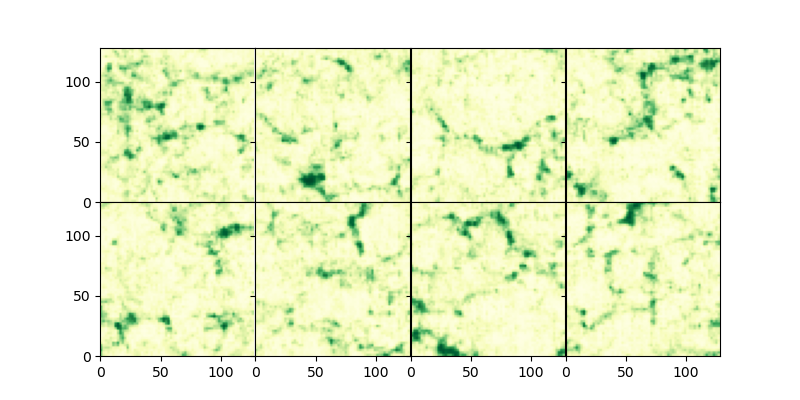

2 4


<IPython.core.display.Javascript object>


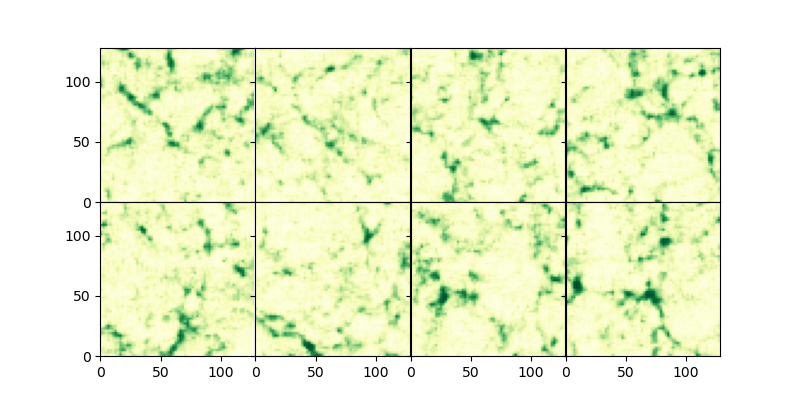

2 4


<IPython.core.display.Javascript object>


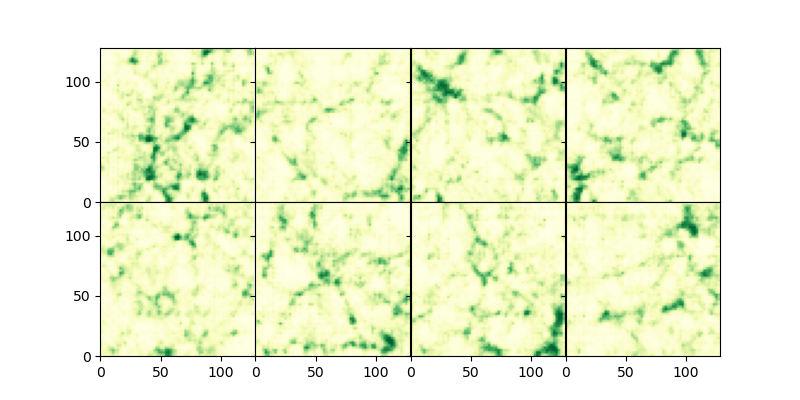

2 4


<IPython.core.display.Javascript object>


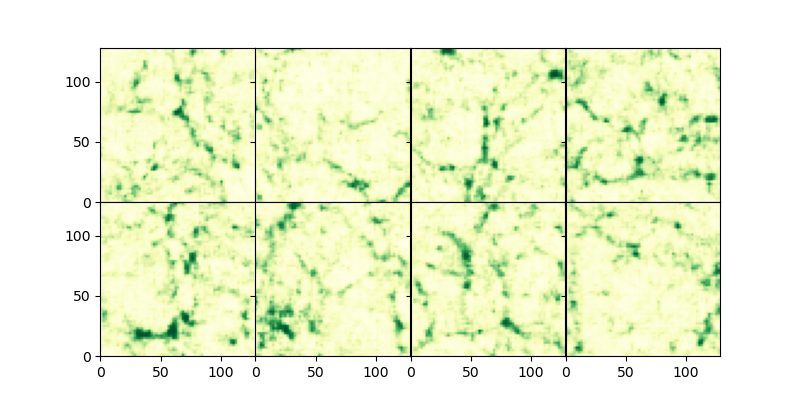

2 4


<IPython.core.display.Javascript object>


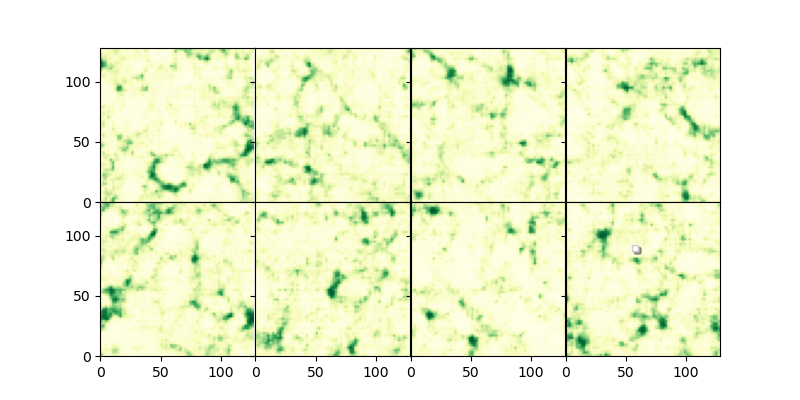

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [34]:
label_lst=['D1_27_3750','D2_18_2500','D3_70_9750','D4_70_9750','D8_61_8550','D16_65_9100']
df=df_runs[df_runs.label.isin(label_lst)]


# f_plot_hist_spec(df,dict_val,'spec_relative',img_size)
# plt.savefig('rel_spectrum.pdf')

# f_plot_hist_spec(df,dict_val,'hist',img_size)
# plt.savefig('pixel_intensity.pdf')


f_plot_hist_spec(df,dict_val,'grid',img_size)


In [25]:
col_list=['label','chi_1','chi_spec1','num_imgs','chi_2','chi_spec2','chi_spec3']
df_runs[col_list]

,label,chi_1,chi_spec1,num_imgs,chi_2,chi_spec2,chi_spec3
8,D4_52_7300,0.541923,4.256442,16,0.001396,1512.786757,43.272089
9,D4_57_8000,0.149051,2.728354,16,0.000535,401.144677,43.564846
10,D4_70_9750,0.231698,3.371871,16,0.001172,1023.487246,43.982168
19,run_ref,0.002667,0.013980,16,0.000021,1.288452,45.228873
6,D2_23_3250,0.199937,3.260661,16,0.001321,1901.615075,45.436353
11,D8_72_10000,0.059347,0.684049,16,0.005132,238.890577,45.694209
18,D16_65_9100,0.069755,0.364337,16,0.004904,226.920225,45.779302
4,D2_18_2500,0.114510,4.891975,16,0.002752,1844.922959,45.976612
2,D1_43_6000,0.240734,7.514688,16,0.014996,4547.278498,46.157433
0,D1_25_3450,0.112749,7.826471,16,0.018053,2270.177117,46.512192
